# Coronavirus 2020 - effectiveness of measures taken

- Please scroll down for plots.

- If you want to execute this, press SHIFT+RETURN to advance code cell to code cell.

- We use data from the files at   https://github.com/CSSEGISandData/COVID19/tree/master/csse_covid_19_data/csse_covid_19_time_series




In [2]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
# Alternative plotting backend for interative data exploration
# %matplotlib notebook
from numpy import log, exp
import os
import pandas as pd

# more interactive plots
import plotly.graph_objects as go

# choose font - can be deactivated
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Inconsolata']

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# suppress warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
LW = 3   # line width

base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

def double_time_exponential(q2_div_q1, t2_minus_t1=None):
    """ See https://en.wikipedia.org/wiki/Doubling_time"""
    if t2_minus_t1 is None:
        t2_minus_t1 = np.ones(q2_div_q1.shape)
    return t2_minus_t1 * np.log(2) / np.log(q2_div_q1) 
    
def fetch_deaths():
    url = os.path.join(base_url, "time_series_covid19_" + "deaths" + "_global.csv")
    df = pd.read_csv(url, index_col=1)
    return df

def fetch_cases():
    url = os.path.join(base_url, "time_series_covid19_" + "confirmed" + "_global.csv")
    df = pd.read_csv(url, index_col=1)
    return df

deaths = fetch_deaths()
cases = fetch_cases()


In [3]:
def get_country(country):
    """Given a country name, return deaths and cases as time series.
    All rows should contain a datetime index and a value"""
    assert country in deaths.index, f"{country} not in available countries. These are {sorted(deaths.index)}"
    
    # Some countries report sub areas (i.e. multiple rows per country):
    if country in ["China", "France", "United Kingdom"]:
        d = deaths.loc[country].sum()
        c = cases.loc[country].sum()
    else:
        d = deaths.loc[country]
        c = cases.loc[country]

    # make date string into timeindex
    d.index = pd.to_datetime(d.index, errors="coerce", format="%m/%d/%y")
    c.index = pd.to_datetime(c.index, errors="coerce", format="%m/%d/%y")
    # drop all rows that don't have data
    # sanity check: how many do we drop?
    if c.index.isnull().sum() > 3:
        print(f"about to drop {c.index.isnull().sum()} entries due to NaT in index", c)
    c = c[c.index.notnull()] 

    if d.index.isnull().sum() > 3:
        print(f"about to drop {d.index.isnull().sum()} entries due to NaT in index", d)
    d = d[d.index.notnull()] 
    
    # check there are no NaN is in the data
    assert c.isnull().sum() == 0, f"{c.isnull().sum()} NaNs in {c}"
    assert d.isnull().sum() == 0, f"{d.isnull().sum()} NaNs in {d}"
    
    # label data
    c.country = country
    c.label = "cases"
    
    d.country = country
    d.label = "deaths"
    
    return c, d

In [4]:
def plot_time_step(ax, series, style="-", logscale=True):
    ax.step(series.index, series.values, style, label=series.country + " " + series.label,
           linewidth=LW)
    if logscale:
        ax.set_yscale('log')
    ax.legend()
    ax.set_ylabel("total numbers")
    return ax

def plot_change_bar(ax, series, color, rolling=None):
    change = series.diff().dropna()   # lose one point at beginning

    if rolling:
        rolling_label = f" {rolling}-day rolling mean"
        rolling_series = change.rolling(rolling, center=True).mean()
        bar_alpha = 0.2
    else:
        rolling_label = ""
        bar_alpha = 1.0

    label = series.country + " new " + series.label 
    ax.bar(change.index, change.values, color=color, label=label, alpha=bar_alpha, 
           linewidth=LW)
    if rolling:
        ax.plot(rolling_series.index, rolling_series.values, color=color, label=label + rolling_label,
                linewidth=LW)
    ax.legend()
    ax.set_ylabel('daily change')
    return ax

def plot_doubling_time(ax, series, color, minchange=10):
    # only keep values where there is a change of a minumum number
    sel = series.diff() <= minchange
    series.drop(series[sel].index, inplace=True)
    
    # we assume we have one value for every day - should check XXX
    q2_div_q1 = series.pct_change() + 1  # computes q2/q1
    q2_div_q1.replace(np.inf, np.nan, inplace=True)  # get rid of x/0 results
    q2_div_q1.dropna(inplace=True)
    dtime = double_time_exponential(q2_div_q1, t2_minus_t1=1)
    dtime.dropna(inplace=True)
    label = series.country + " new " + series.label 
    ax.plot(dtime.index, dtime.values, 'o', color=color, alpha=0.3, label=label)
    
    # need rolling average to smooth out weekly variations
    rolling = dtime.rolling(7, center=True).mean()
        
    # good to take maximum value from here
    ymax = min(rolling.max()*1.5, 500)
    if np.isnan(ymax):
        # This happens is rolling is empty, for example for deaths in Austria, Singapore
        print(f"Can't plot doublingtime line for {series.label} in {series.country} due to too small numbers")
        ymax = 10
        
    # some countries require special care
    if series.country == 'China':
            ymax = 100        
        
    ax.set_ylim(0, ymax)
    ax.plot(dtime.index, rolling, "-", color=color, alpha=1.0, label=label + ' 7-day rolling mean',
            linewidth=LW)
    ax.legend()
    ax.set_ylabel("doubling time [days]")
    return ax, rolling, dtime

In [5]:
def overview(country):
    c, d = get_country(country)

    fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=False)
    ax = axes[0]
    plot_time_step(ax=ax, series=c, style="-C1")
    plot_time_step(ax=ax, series=d, style="-C0")

    ax = axes[1]
    plot_change_bar(ax=ax, series=c, rolling=7, color="C1")
    if country == "China":
        ax.set_ylim(0, 5000)

    ax = axes[2]
    plot_change_bar(ax=ax, series=d, rolling=7, color="C0")

    ax = axes[3]
    plot_doubling_time(ax, series=d, color="C0")
    plot_doubling_time(ax, series=c, color="C1")
    
    # enforce same x-axis on all plots
    axes[1].set_xlim(axes[0].get_xlim())
    axes[2].set_xlim(axes[0].get_xlim())
    axes[3].set_xlim(axes[0].get_xlim())

    
    fig.tight_layout(pad=1)
    
    title = f"Overview {c.country}, last data point from {c.index[-1].date().isoformat()}"
    axes[0].set_title(title, )

    filename = os.path.join("figures", c.country.replace(" ", "-").replace(",", "-") + '.svg')
    fig.savefig(filename)
    
    return axes, c, d


# China, South Korea, Singapore

## China

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


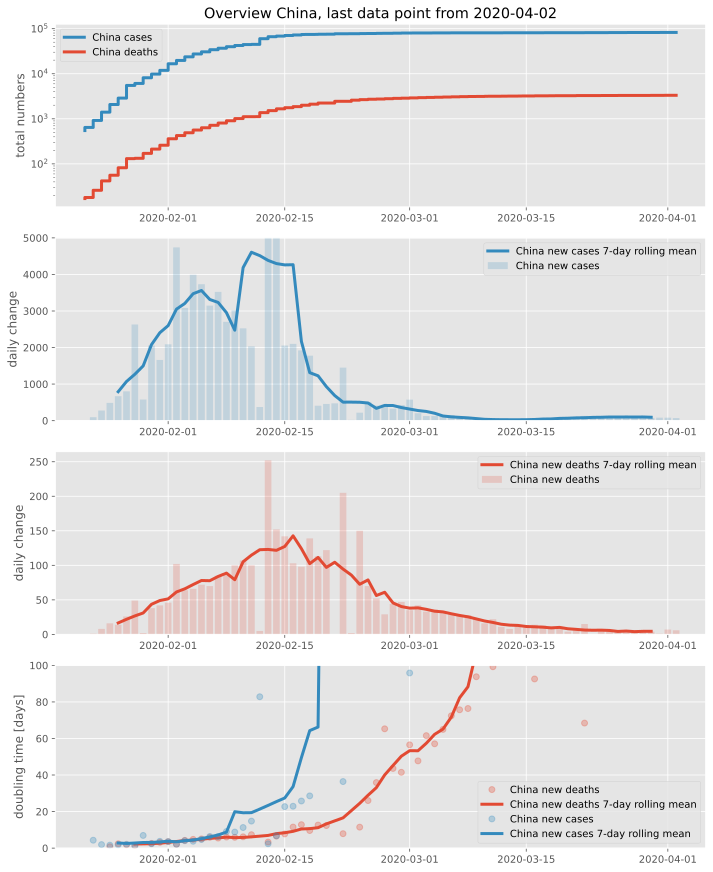

In [6]:
overview("China");

## South Korea

Can't plot doublingtime line for deaths in Korea, South due to too small numbers


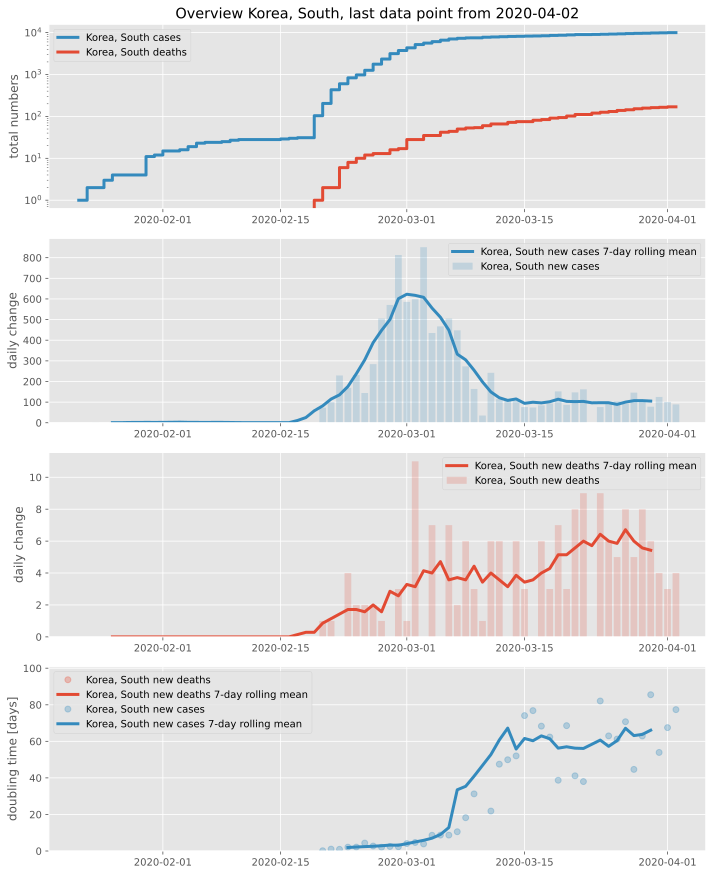

In [7]:
overview("Korea, South");

## Singapore

Can't plot doublingtime line for deaths in Singapore due to too small numbers


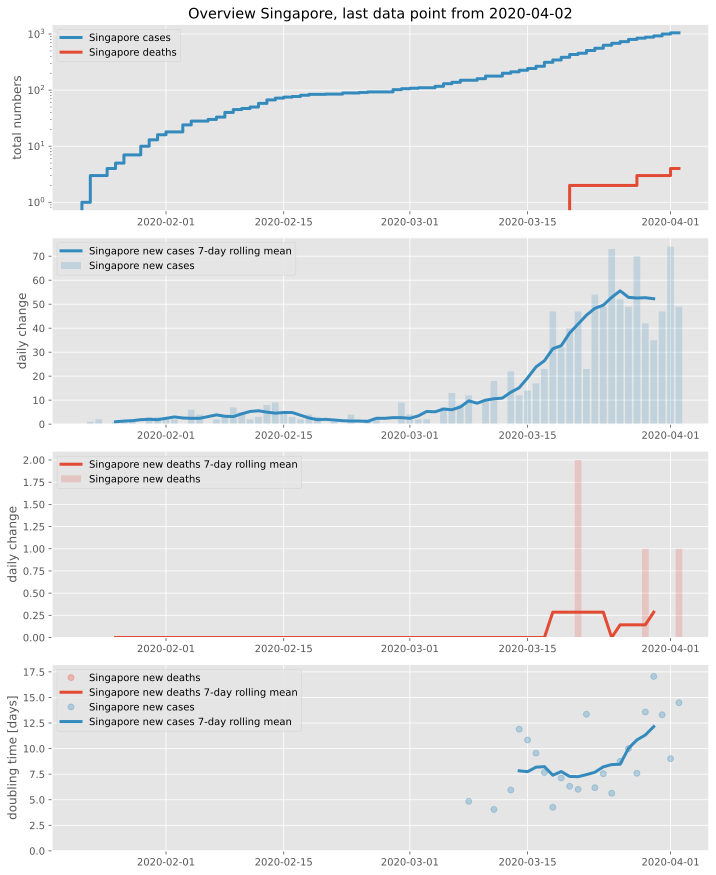

In [8]:
overview("Singapore");

# Countries with large numbers of reported infections

## United States

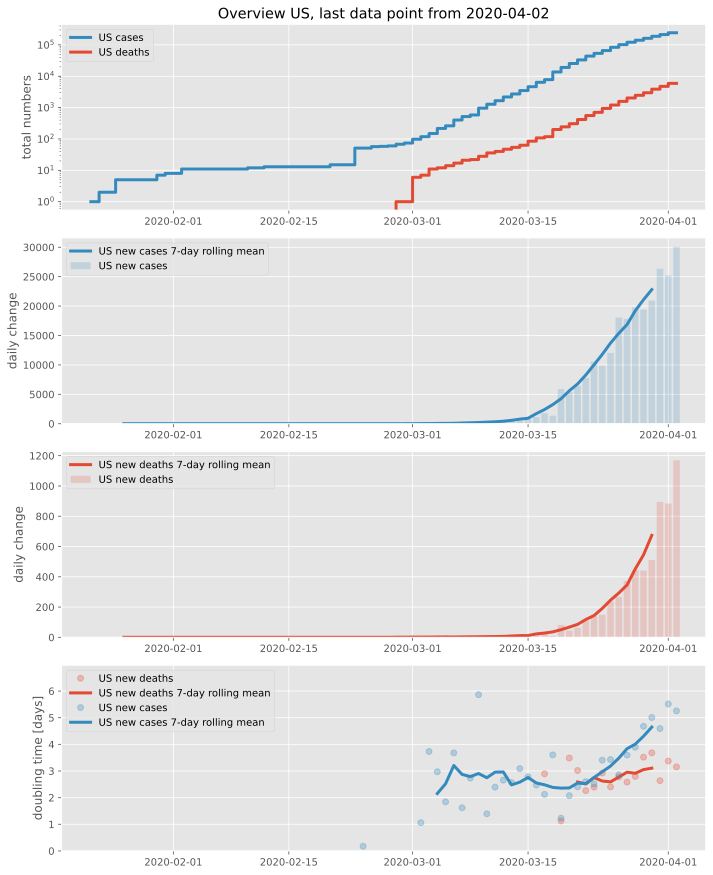

In [9]:
overview("US");

## Italy

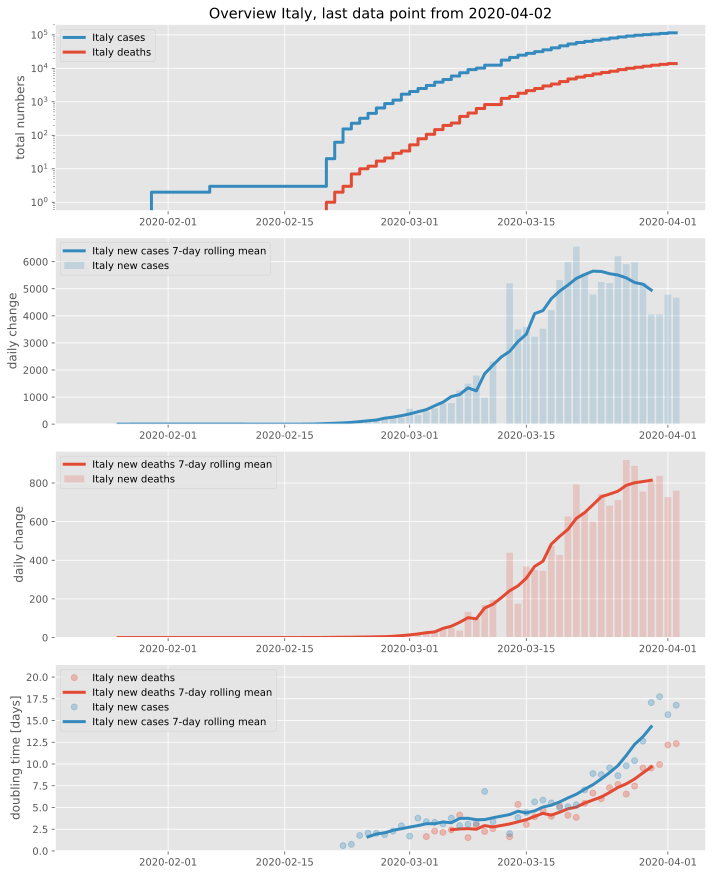

In [10]:
overview("Italy");

## Spain

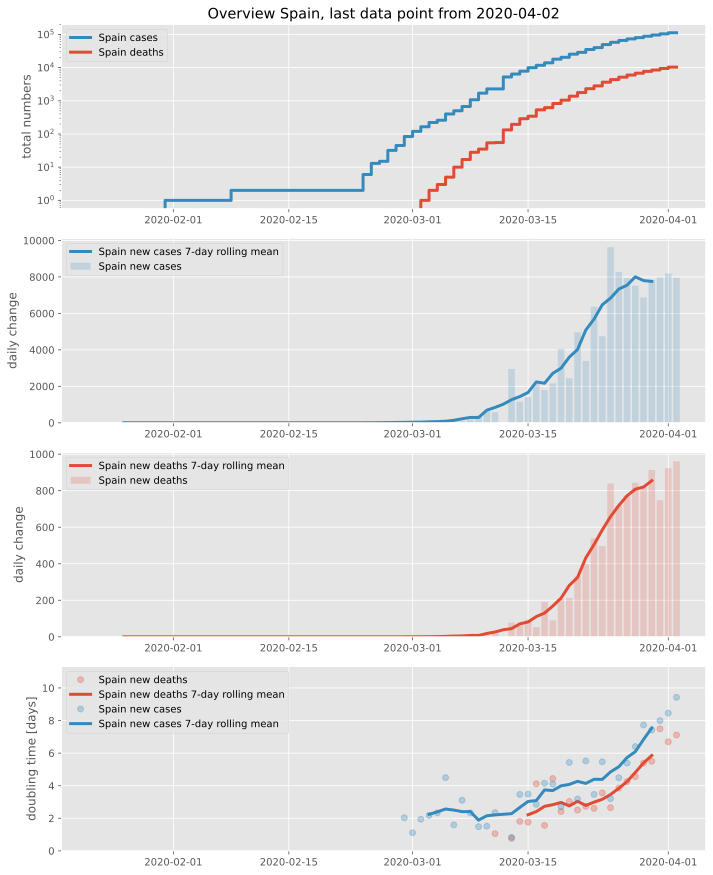

In [11]:
overview("Spain");

## Germany

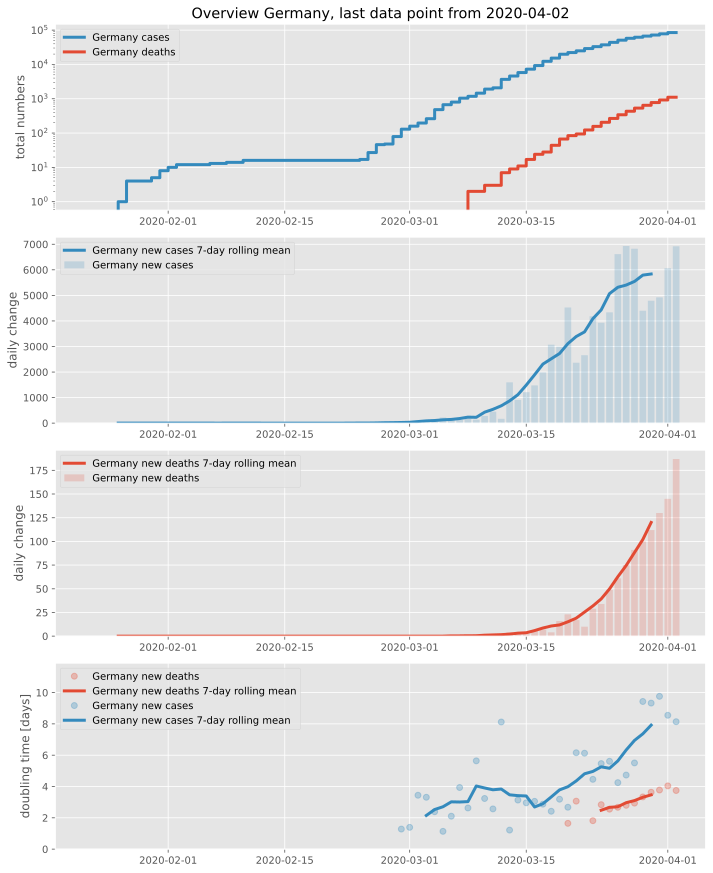

In [12]:
overview("Germany");

## France

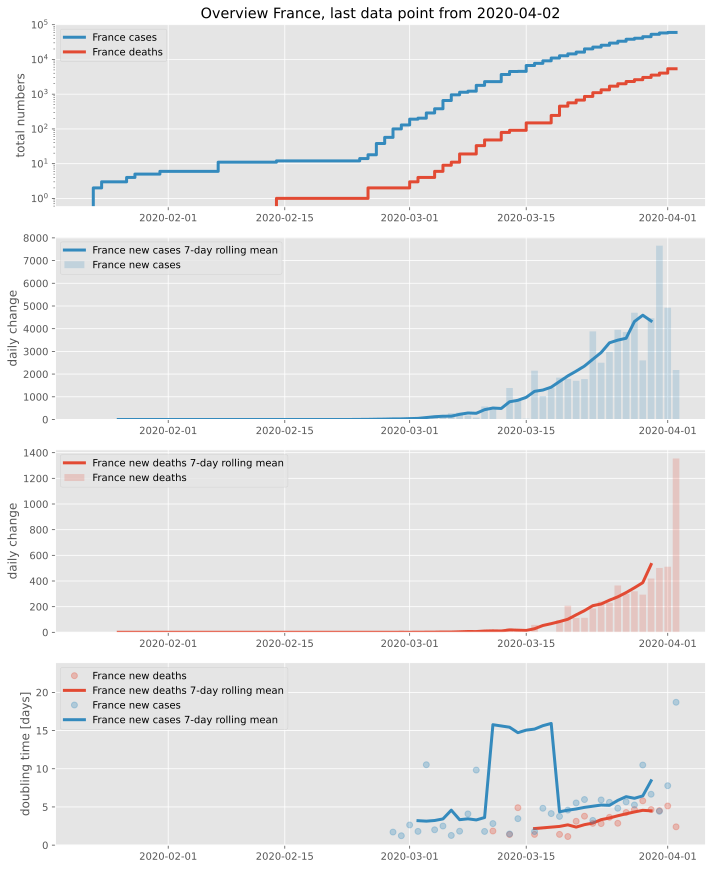

In [13]:
overview("France");

## Iran

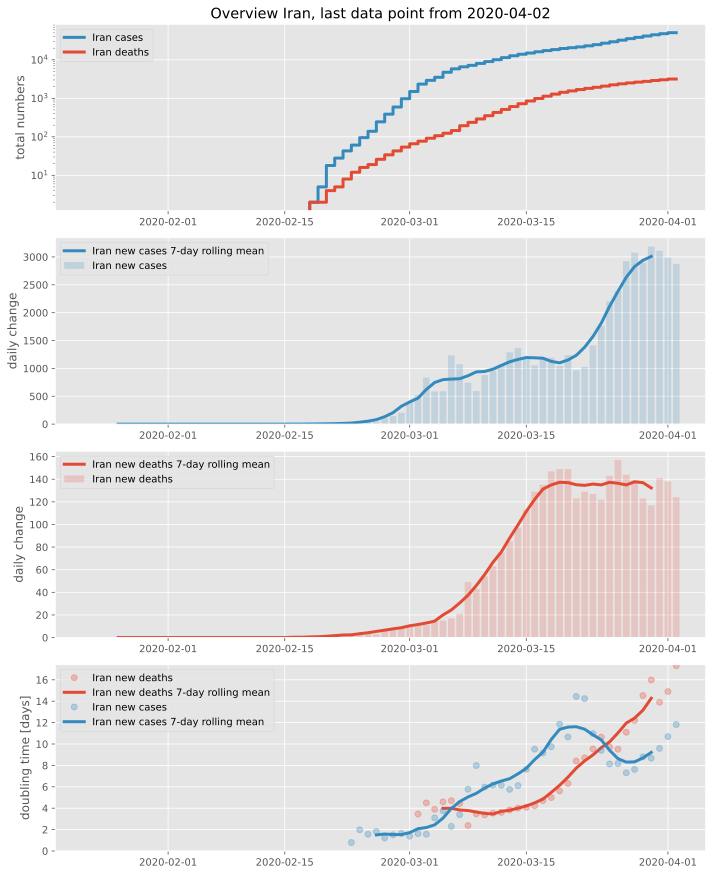

In [14]:
overview("Iran");

## United Kingdom

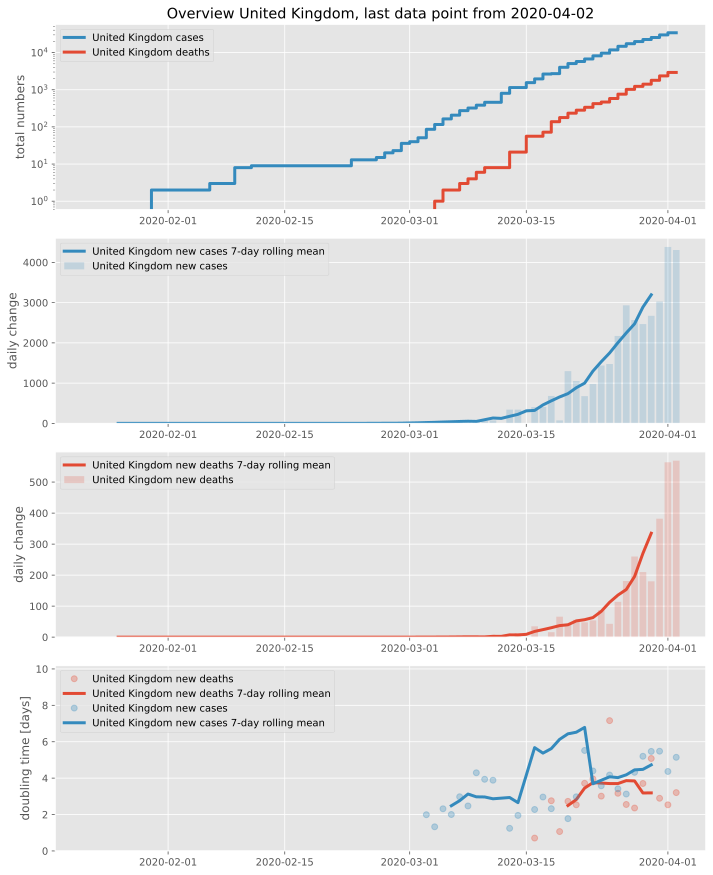

In [15]:
overview("United Kingdom");

## Switzerland

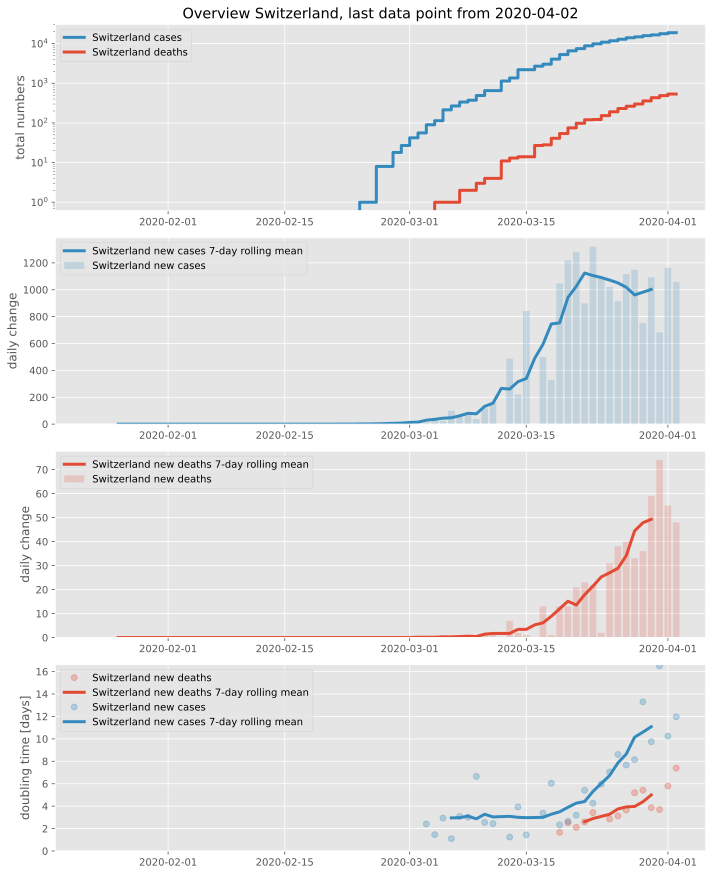

In [16]:
overview("Switzerland");

##  Austria

Can't plot doublingtime line for deaths in Austria due to too small numbers


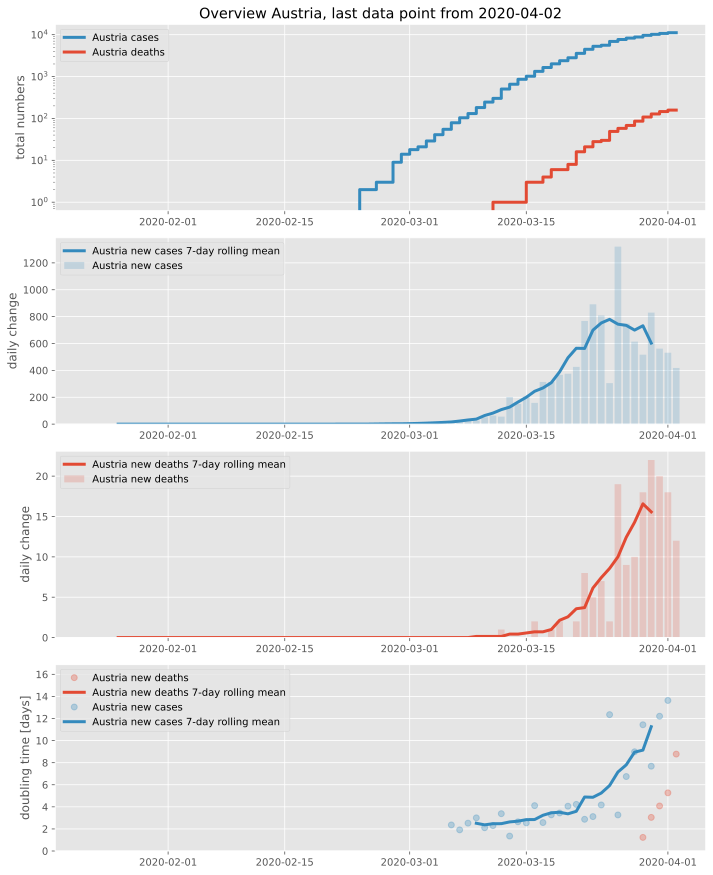

In [17]:
overview("Austria");

In [29]:
world_countries = {}
countries = ["China", "Korea, South", "Singapore", "US", "Italy", "Spain", "Germany", "France",
             "Iran", "United Kingdom", "Switzerland", "Austria"]
for country in countries:
    world_countries[country] = get_country(country)

In [36]:
fig = go.Figure()

for country in countries:
    fig.add_trace(go.Scatter(x=world_countries[country][0].index, y=world_countries[country][0], name=country))

fig.update_traces(mode='markers', marker_line_width=2, marker_size=10)
fig.update_layout(title = f" Global Overview, last data point from {c_China.index[-1].date().isoformat()}",
                  yaxis_title='Total numbers of cases')

fig.show();

In [37]:
fig = go.Figure()

for country in countries:
    fig.add_trace(go.Scatter(x=world_countries[country][1].index, y=world_countries[country][1], name=country))

fig.update_traces(mode='markers', marker_line_width=2, marker_size=10)
fig.update_layout(title = f" Global Overview, last data point from {c_China.index[-1].date().isoformat()}",
                  yaxis_title='Total numbers of deaths')

fig.show();